In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import ipdb
import tensorflow as tf
from keras.backend import set_session
from keras.utils import multi_gpu_model

# import horovod.keras as hvd
import math
# Horovod: initialize Horovod.
# hvd.init()

/ccs/home/shubhankar/summitdev/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#setting tf options to avoid hogging gpu memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.visible_device_list = str(hvd.local_rank())

set_session(tf.Session(config=config))

In [3]:
# train_data = pd.read_csv('/mnt/GATES/rnd_data/data/train.csv') # S Mapper 5
train_data = pd.read_csv('/gpfs/alpine/gen011/world-shared/data/train.csv')  # Summit/SummitDev

classes, counts = np.unique(train_data.category, return_counts = True)
# plt.figure(figsize=(20,10))
# ax = sns.distplot(train_data.category)
# plt.xticks(np.arange(min(classes), max(classes)+1, 10))

In [4]:
train_data.head(5)
int(train_data.loc[train_data['image_id'] == 3, 'category'])

72

<BarContainer object of 102 artists>

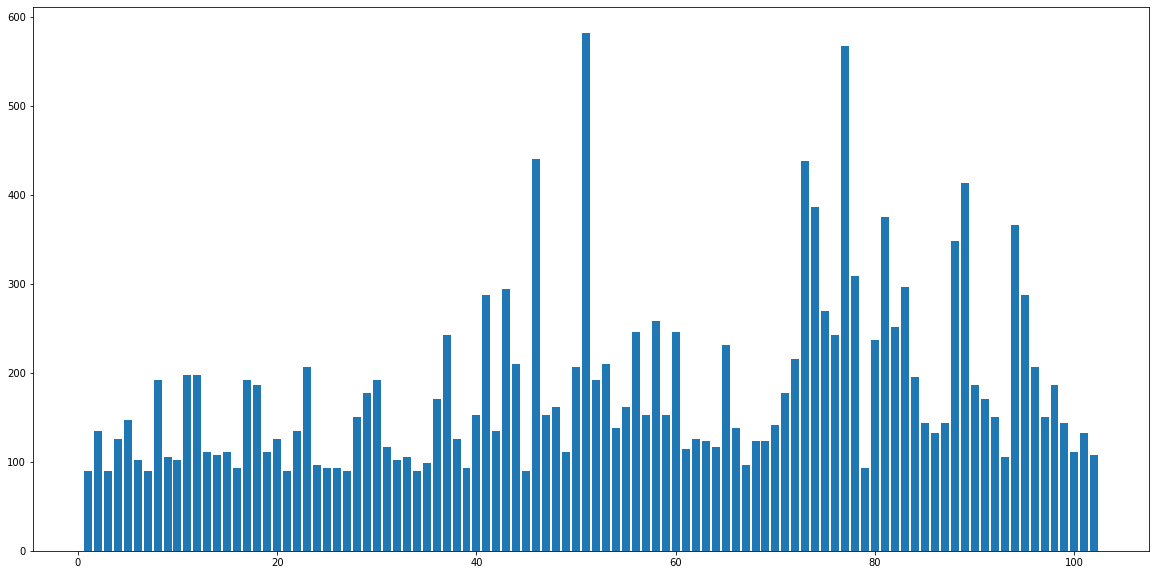

In [5]:
plt.figure(figsize=(20,10))
plt.bar(classes,counts)

In [6]:
np.max(counts)

582

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=10, stratify=train_data.category.values)

<BarContainer object of 102 artists>

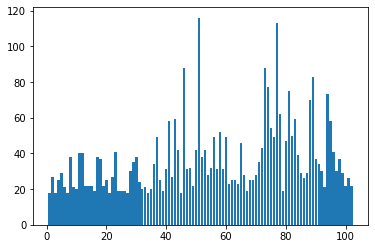

In [8]:
val_classes, val_counts = np.unique(val_df.category, return_counts=True)
plt.bar(val_classes,val_counts)

<BarContainer object of 102 artists>

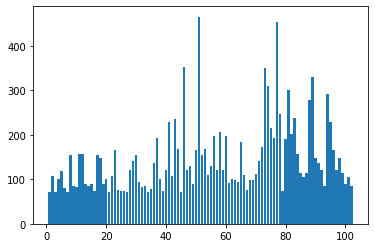

In [9]:
train_classes, train_counts = np.unique(train_df.category, return_counts=True)
plt.bar(train_classes,train_counts)

In [10]:
import glob2

def get_fnames(df, part, data_path, ext='.jpg'):
    
    #all_fnames = glob2.glob(data_path+part+'/*'+ext)
    all_fnames=[]
    for img_id in df.image_id.values:
        all_fnames.append(data_path+part+'/'+str(img_id)+ext)
        
    return all_fnames

In [11]:
# Creating Data Generator class

"""
This class reads data based on filenames and returns normalised Image arrays and labels.
Labels can be of type Mask images or Integer counts.
Mask images are normalised and returned as well.
"""

from keras.utils import Sequence
from keras.utils import to_categorical
from PIL import Image
        
class data_generator(Sequence):
    def __init__(self, filenames_set, batch_size, data_frame):
        self.filenames = filenames_set
        self.batch_size = batch_size
        self.df = data_frame
        self.n = 0
        self.max = self.__len__()
        
    def get_data(self, filename):
        
        img = np.asarray(Image.open(filename))
        img_id = int(filename.split('/')[-1].split('.')[0])
        label = int(self.df.loc[self.df['image_id'] == img_id, 'category'])
        
        return img, label

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_files = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]

        # read your data here using the batch lists, batch_x and batch_y
        img_array = []
        label_array = []
        for filename in batch_files:
            img, label = self.get_data(filename)
            img_array.append(img)
            label_array.append(label)
        
        img_array = np.asarray(img_array)
        label_array = np.asarray(label_array)
        label_array = to_categorical(label_array, num_classes=102, dtype='int8')
        
        return img_array, label_array
            
    
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

In [12]:
import glob2

# train_filenames_set = get_fnames(train_df, part='train',data_path='/mnt/GATES/rnd_data/data/') # S Mapper 5
train_filenames_set = get_fnames(train_df, part='train',data_path='/gpfs/alpine/gen011/world-shared/data/') # Summit/SummitDev
train_generator = data_generator(train_filenames_set, batch_size=58, data_frame=train_df)

In [13]:
# val_filenames_set = get_fnames(val_df, part='train',data_path='/mnt/GATES/rnd_data/data/') # S Mapper 5
val_filenames_set = get_fnames(val_df, part='train',data_path='/gpfs/alpine/gen011/world-shared/data/') # Summit/SummitDev
val_generator = data_generator(val_filenames_set, batch_size=58, data_frame=val_df)

In [14]:
img, labels = next(val_generator)
print(labels.shape)

(58, 102)


In [15]:
#keras model related imports
import tensorflow as tf
from keras.layers import *
from keras.models import Model, load_model
from keras.applications import ResNet50, DenseNet121
from keras_contrib.callbacks import TensorBoardGrouped
from keras.regularizers import Regularizer, l1, l1_l2, l2
from keras import regularizers
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau,ModelCheckpoint,CSVLogger,EarlyStopping
from keras.optimizers import Adam, SGD


In [16]:
def get_model(base_model):
    
    model_in = base_model.output
    conv_add1 = Conv2D(2048, kernel_size=(3,3), strides=(2,2))(model_in)
    bn_add1 = BatchNormalization()(conv_add1)
    act_add1 = Activation('relu')(bn_add1)
    flat = Flatten()(act_add1)
    den1 = Dense(1024)(flat)
    out = Dense(102, activation='softmax')(den1)
    model = Model(inputs=base_model.input, outputs = out)
    opt = Adam(lr = 1e-3 ) #* hvd.size())
#     opt = hvd.DistributedOptimizer(opt)
    model = multi_gpu_model(model, gpus=4)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [17]:
resnet_model = get_model(ResNet50(include_top=False, weights='imagenet', input_shape=(500,500,3), pooling=None, classes=102))

Instructions for updating:
Colocations handled automatically by placer.


/ccs/home/shubhankar/summitdev/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [18]:
# resnet_model.summary()

In [19]:
from time import gmtime, strftime

epochs = 100 #int(math.ceil(100.0 / hvd.size()))


#Define all callbacks to the keras model

# tb_dir = "/mnt/GATES/rnd_data/logs/resnet50/"+ strftime("%Y-%m-%d-gmt-%H-%M-%S", gmtime()) # S Mapper 5
tb_dir = "/gpfs/alpine/gen011/world-shared/shubhankar/logs/resnet50/"+ strftime("%Y-%m-%d-gmt-%H-%M-%S", gmtime())  # Summit/SummitDev
tb_callback = TensorBoardGrouped(log_dir=tb_dir, histogram_freq=0, batch_size=1187, write_graph=False, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)
# csv_logger = CSVLogger('/mnt/GATES/rnd_data/logs/resnet50/training_log'+ strftime("%Y-%m-%d-gmt-%H-%M-%S", gmtime())+'.csv') # S Mapper 5
csv_logger = CSVLogger('/gpfs/alpine/gen011/world-shared/shubhankar/logs/resnet50/training_log'+ strftime("%Y-%m-%d-gmt-%H-%M-%S", gmtime())+'.csv') # Summit/SummitDev


# ckpt_callback = ModelCheckpoint('/mnt/GATES/rnd_data/models/resnet50/resnet_model'+strftime("%Y-%m-%d-gmt-%H-%M-%S", gmtime())+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min') # S Mapper 5

ckpt_callback = ModelCheckpoint('/gpfs/alpine/gen011/world-shared/shubhankar/flower_models/resnet50/resnet_model'+strftime("%Y-%m-%d-gmt-%H-%M-%S", gmtime())+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  # Summit/SummitDev

# hvd_callback =  hvd.callbacks.BroadcastGlobalVariablesCallback(0),

el_stp_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

# clr_callback = CyclicLR(base_lr=1e-3, max_lr=1e-5,
#                                 step_size=10., mode='triangular2')

clbk_list=[tb_callback, lr_callback, ckpt_callback, csv_logger]

# if hvd.rank() == 0:
#     clbk_list.append(ckpt_callback)

#Model fitting on training data
resnet_history = resnet_model.fit_generator(train_generator, steps_per_epoch=None, epochs=epochs, verbose=1, callbacks=clbk_list, validation_data=val_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
